In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from common_util import LogLinearArrheniusModelFunc,generalized_logistic,setup_axis_default
import pickle
from scipy.optimize import bisect
from typing import Tuple

def get_time_to_rx(rx_model: LogLinearArrheniusModelFunc, 
                   temp: float, 
                   X: float,
                   bounds: Tuple[int]) -> float:

    def _func(t: float) -> float:
        return rx_model.predict(np.array([[t, temp]])).squeeze() - X

    return bisect(_func, *bounds)


### Single Model, multiple temperature

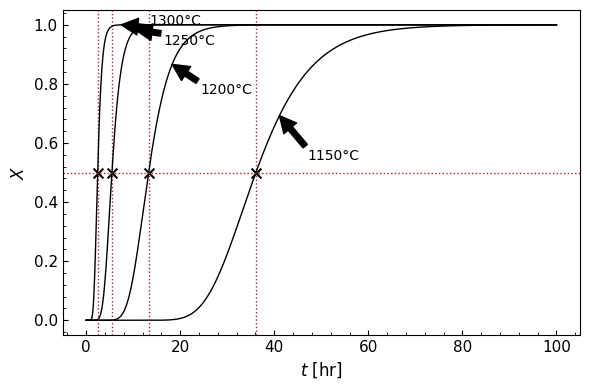

In [13]:
with open('.model/Generalized Logistic_alfonso_data_hr_robust weighted.pkl', 'rb') as f:
    rx_model = pickle.load(f)

fig,ax = plt.subplots(1,1,figsize = (6,4))
setup_axis_default(ax)
ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel('$X$',fontsize = 12)

temperature = np.array([1150,1200,1250,1300])
time = np.linspace(0, 100, 1000)*3600

i = 0
for temp in temperature:
    temp_ = np.ones_like(time)*(temp + 273.15)
    rx = rx_model.predict(np.array([time,temp_]).T)
    half_time = get_time_to_rx(rx_model, temp + 273.15, 0.5, (0, 100*3600))
    ax.scatter([half_time/3600],[0.5],s = 50,marker = 'x',color = 'k')
    ax.axvline(half_time/3600,ls = ':',color = 'firebrick',lw = 1.)
    ax.plot(time/3600,rx,ls = '-',lw = 1.,color = 'k')

    # Add arrow and label
    arrow_x = half_time / 3600 + 5  # Adjust the x position of the arrow
    arrow_y = rx_model.predict(np.array([[half_time + 5 * 3600, temp + 273.15]]))[0]
    ax.annotate(f'{temp}°C', xy=(arrow_x, arrow_y), xytext=(arrow_x + 6, arrow_y -0.15 + 0.05*i),
                arrowprops=dict(facecolor='black',edgecolor ='k',shrink=0.001))
    
    i+=1
    
ax.axhline(0.5,ls = ':',color = 'firebrick',lw = 1.) 
fig.tight_layout()
fig.savefig('visualization/alfonso_hr_four_temps.pdf',bbox_inches = 'tight',dpi = 500)


### Differences Between Models

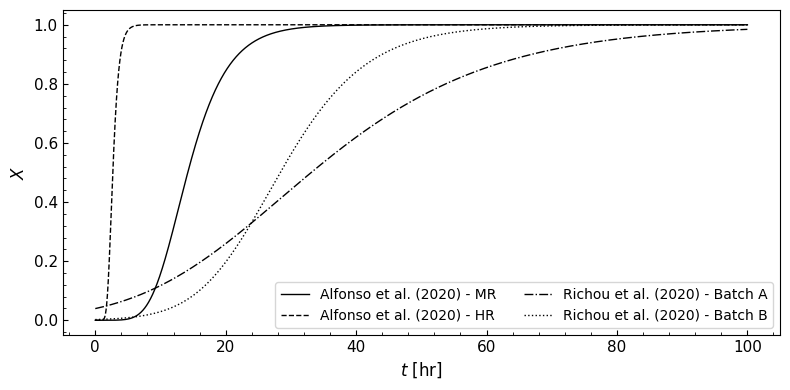

In [12]:
models_files = ['Generalized Logistic_alfonso_data_mr_robust weighted.pkl',
    'Generalized Logistic_alfonso_data_hr_weighted.pkl',
                
                'Generalized Logistic_richou_batch_a_robust weighted.pkl',
                'Generalized Logistic_richou_batch_b_robust weighted.pkl'
]

line_styles = ['-', '--', '-.', ':']
line_styles = ['-','--','-.',':']

labels = ['Alfonso et al. (2020) - MR',
          'Alfonso et al. (2020) - HR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B'
]

fig,ax = plt.subplots(1,1,figsize = (8,4))
setup_axis_default(ax)
ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel('$X$',fontsize = 12)
time = np.linspace(0, 100, 10000)

for model_file,linestyle,label in zip(models_files,line_styles,labels):
    with open(f'.model/{model_file}', 'rb') as f:
        rx_model = pickle.load(f)

    rx = rx_model.predict(np.array([time*3600,np.ones_like(time)*(1300 + 273.15)]).T)
    ax.plot(time,rx,lw = 1.,ls = linestyle,label = label,color = 'k')

ax.legend(fontsize = 10,ncols = 2)

fig.tight_layout()
fig.savefig('visualization/alloy_comparison_1300C.pdf',bbox_inches = 'tight',dpi = 500)
    

### Time To Reach $X = 1/2$

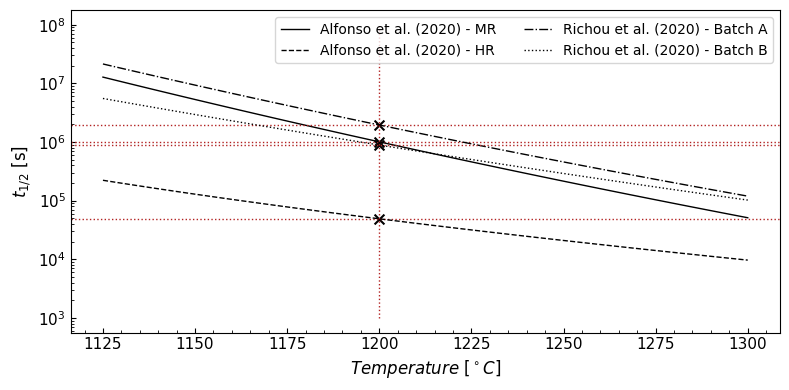

In [22]:
models_files = ['Generalized Logistic_alfonso_data_mr_robust weighted.pkl',
    'Generalized Logistic_alfonso_data_hr_weighted.pkl',
                
                'Generalized Logistic_richou_batch_a_robust weighted.pkl',
                'Generalized Logistic_richou_batch_b_robust weighted.pkl'
]

line_styles = ['-', '--', '-.', ':']
line_styles = ['-','--','-.',':']

labels = ['Alfonso et al. (2020) - MR',
          'Alfonso et al. (2020) - HR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B'
]

fig,ax = plt.subplots(1,1,figsize = (8,4))
setup_axis_default(ax)
ax.set_xlabel(r'$Temperature$ [$^\circ C$]',fontsize = 12)
ax.set_ylabel(r'$t_{1/2}$ [s]',fontsize = 12)

temperatures = np.linspace(1125,1300,100)
for model_file,linestyle,label in zip(models_files,line_styles,labels):
    with open(f'.model/{model_file}', 'rb') as f:
        rx_model = pickle.load(f)

    half_times = np.zeros_like(temperatures)
    for i,temp in enumerate(temperatures):
        half_times[i] = get_time_to_rx(rx_model, temp + 273.15, 0.5, (1., 1e4*3600))

    ht = get_time_to_rx(rx_model, 1200 + 273.15, 0.5, (1., 1e4*3600))
    ax.axhline(ht,ls = ':',color = 'firebrick',lw = 1.)
    ax.scatter([1200],[ht],s = 50,marker = 'x',color = 'k')

    
    ax.plot(temperatures,half_times,lw = 1.,ls = linestyle,label = label,color = 'k')

ax.plot(np.ones(100)*1200,np.logspace(3,8,100),ls = ':',color = 'firebrick',lw = 1.)
ax.legend(fontsize = 10,ncols = 2)

ax.set_yscale('log')
fig.tight_layout()
fig.savefig('visualization/half_time_comparison.pdf',bbox_inches = 'tight',dpi = 500)